# Import Libraries

In [1]:
import pandas as pd
import numpy as np

#Use Keras Neural Network Components. This will be used to construct the LSTM
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.layers import LayerNormalization
from keras.layers import MultiHeadAttention
from keras.regularizers import L1L2
from keras.layers import Layer
from keras import Model

#Import Tensorflow 
import tensorflow as tf

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

2023-12-07 20:32:33.243693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Ensure Reproducability of Results

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Fetch and Set Up Data

In [3]:
#Numerically Encode the Activities
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [4]:
DATDIR = "data/UCI HAR Dataset"
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [5]:
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_raw_signal_data(train_test, signal):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/Inertial Signals/{signal}_{'train' if train_test == 0 else 'test'}.txt"
    return pd.read_csv(file_path, delim_whitespace = True, header = None)

#Same purpose as previous function but, in this case, we are fetching ALL the raw signal data!
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_all_raw_signals(train_test):
    data_raw_signals = []
    for signal in SIGNALS:
        raw_signal_data = fetch_raw_signal_data(train_test, signal).to_numpy()
        data_raw_signals.append(raw_signal_data)
    
    data_raw_signals = np.array(data_raw_signals)
    return np.transpose(data_raw_signals, axes = (1, 2, 0))

#Fetch Labels
#train_test: 0 if we want to fetch the training signal data, 1 if we want to fetch the test signal data
def fetch_labels(train_test):
    file_path = DATDIR + f"/{'train' if train_test == 0 else 'test'}/y_{'train' if train_test == 0 else 'test'}.txt"
    return pd.get_dummies(pd.read_csv(file_path, delim_whitespace=True, header = None)[0]).to_numpy()

In [6]:
X_train, X_test, Y_train, Y_test = fetch_all_raw_signals(0), fetch_all_raw_signals(1), fetch_labels(0), fetch_labels(1)

N = X_train.shape[0]
T = X_train.shape[1]
D = X_train.shape[2]

print(N, T, D)

n_classes = Y_train.shape[1]
print(n_classes)
print(X_train.shape, Y_train.shape)

7352 128 9
6
(7352, 128, 9) (7352, 6)


# Define LSTM Architecture

## Architecture 1: 2 LSTM Layers With Attention Layer

In [7]:
##Hyperparameters
epochs = 30
batch_size = 16

n_hidden_1 = 64
n_hidden_2 = 32
n_hidden_3 = 16
n_hidden_4 = 8

dropout_p = 0.5
num_heads = 6

In [8]:
class AttentionBlock(Layer):
    def __init__(self, num_heads, key_dim, fc_dim):
        super().__init__()
        self.dropout = Dropout(0.1)
        self.attention = MultiHeadAttention(num_heads = num_heads, key_dim = key_dim, value_dim = key_dim)
        self.fc = Sequential([Dense(fc_dim, activation="relu")])
        
    def call(self, inputs, training):
        attention_output = self.attention(inputs, inputs)
        attention_output = self.dropout(attention_output, training = training)        
        fc_output = self.fc(attention_output)
        fc_output = self.dropout(fc_output, training = training)
        return fc_output


In [9]:
model = Sequential() #Initializing our Model Architecture

model.add(LSTM(n_hidden_1, input_shape = (T, D), return_sequences=True)) # Add an LSTM Layer
model.add(AttentionBlock(num_heads = num_heads, key_dim = n_hidden_1, fc_dim = n_hidden_2)) #Add a Multihead Attention Layer
model.add(BatchNormalization()) #Add Batch Normalization Layer

model.add(LSTM(n_hidden_3)) #Add another LSTM to come after the AttentionBlock
model.add(BatchNormalization()) #Add Batch Normalization Layer

model.add(Dense(n_hidden_4, activation = "relu")) #Add another Dense Layer
model.add(Dropout(dropout_p)) # Adding a dropout layer
model.add(Dense(n_classes, activation = 'softmax')) #Adding a Dense Layer with the Softmax Activation Function

model.summary() #Display a Summary of our model architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 64)           18944     
                                                                 
 attention_block (Attention  (None, 128, 32)           101600    
 Block)                                                          
                                                                 
 batch_normalization (Batch  (None, 128, 32)           128       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                        

In [10]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [11]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 62s 127ms/step - loss: 1.2856 - accuracy: 0.4557 - val_loss: 0.5514 - val_accuracy: 0.8605
Epoch 2/30
460/460 [==============================] - 58s 125ms/step - loss: 0.8558 - accuracy: 0.6133 - val_loss: 0.3497 - val_accuracy: 0.8860
Epoch 3/30
460/460 [==============================] - 65s 142ms/step - loss: 0.7724 - accuracy: 0.6382 - val_loss: 0.3054 - val_accuracy: 0.9067
Epoch 4/30
460/460 [==============================] - 68s 148ms/step - loss: 0.7348 - accuracy: 0.6590 - val_loss: 0.2706 - val_accuracy: 0.9118
Epoch 5/30
460/460 [==============================] - 66s 142ms/step - loss: 0.6989 - accuracy: 0.6944 - val_loss: 0.2267 - val_accuracy: 0.9223
Epoch 6/30
460/460 [==============================] - 53s 116ms/step - loss: 0.6628 - accuracy: 0.7012 - val_loss: 0.2185 - val_accuracy: 0.9199
Epoch 7/30
460/460 [==============================] - 54s 117ms/step - loss: 0.6635 - accuracy: 0.6961 - val_loss: 0.2586 - val_ac

In [12]:
def generate_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [13]:
#Generate Confusion Matrix
confusion_matrix = generate_confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 9s 83ms/step


/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_52347/548805115.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


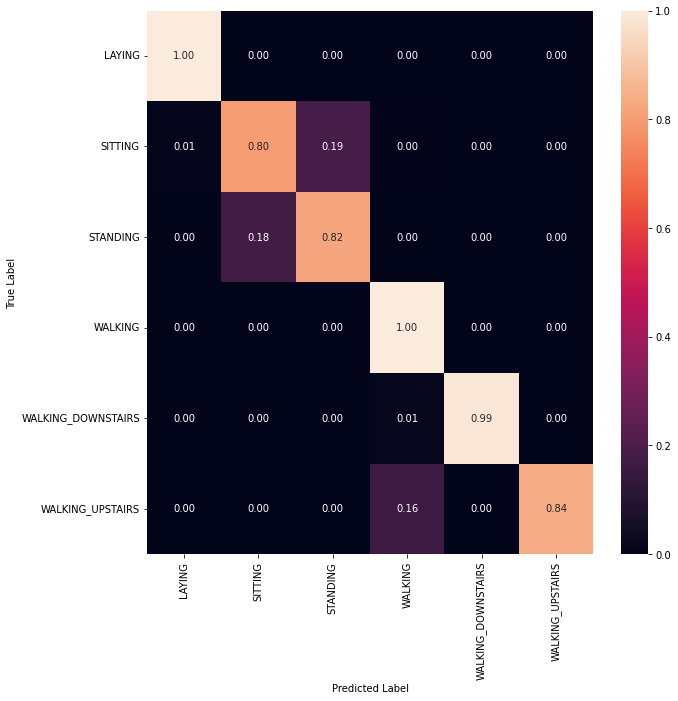

In [14]:
#Plot Normalized Confusion Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [15]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 8s 80ms/step - loss: 0.3831 - accuracy: 0.9067

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.38313978910446167, 0.9066847562789917]


## Architecture 2: Use 2 LSTM Layers

In [16]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 64
dropout_p = 0.5
n_hidden_2 = 32
n_hidden_3 = 16

In [17]:
model = Sequential() #Initializing our Model Architecture

#Define LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_1, input_shape=(T, D), return_sequences=True))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define the second LSTM Layer with Batch Normalization
model.add(LSTM(n_hidden_2))
model.add(BatchNormalization())

#Define Dropout Layer
model.add(Dropout(dropout_p))

#Define Dense Layer
model.add(Dense(n_hidden_3, activation = 'relu'))

#Define Dense Layer
model.add(Dense(n_classes, activation = 'softmax'))

#Print Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128, 64)           18944     
                                                                 
 batch_normalization_2 (Bat  (None, 128, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 32)               

In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 32s 62ms/step - loss: 0.9190 - accuracy: 0.6232 - val_loss: 0.7445 - val_accuracy: 0.7143
Epoch 2/30
460/460 [==============================] - 28s 60ms/step - loss: 0.5089 - accuracy: 0.8111 - val_loss: 0.4054 - val_accuracy: 0.8541
Epoch 3/30
460/460 [==============================] - 27s 59ms/step - loss: 0.3105 - accuracy: 0.8896 - val_loss: 0.3239 - val_accuracy: 0.8846
Epoch 4/30
460/460 [==============================] - 26s 57ms/step - loss: 0.2419 - accuracy: 0.9173 - val_loss: 0.3862 - val_accuracy: 0.8938
Epoch 5/30
460/460 [==============================] - 23s 50ms/step - loss: 0.2362 - accuracy: 0.9210 - val_loss: 0.2792 - val_accuracy: 0.8968
Epoch 6/30
460/460 [==============================] - 23s 50ms/step - loss: 0.2046 - accuracy: 0.9289 - val_loss: 0.3233 - val_accuracy: 0.9050
Epoch 7/30
460/460 [==============================] - 23s 51ms/step - loss: 0.2007 - accuracy: 0.9316 - val_loss: 0.2568 - val_accuracy:

In [20]:
#Generate Confusion Matrix
confusion_matrix = generate_confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 2s 16ms/step


/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_52347/548805115.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


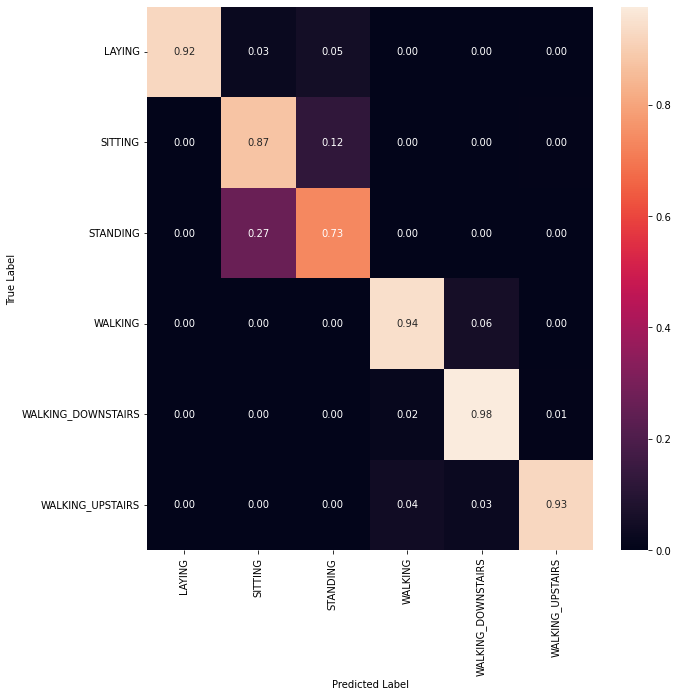

In [21]:
#Plot Normalized Confusion Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [22]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 16ms/step - loss: 0.5296 - accuracy: 0.8924

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.5295603275299072, 0.8924329876899719]


## Architecture 3: Use 1 LSTM Layer

In [23]:
##Hyperparameters
epochs = 30
batch_size = 16
n_hidden_1 = 32
n_hidden_2 = 16
dropout_p = 0.5

In [24]:
model = Sequential() #Initializing our Model Architecture

# Add an LSTM Layer
model.add(LSTM(n_hidden_1, input_shape = (T, D)))

# Adding a dropout layer
model.add(Dropout(dropout_p))

#Add another Dense Layer
model.add(Dense(n_hidden_2, activation = "relu"))

# Adding a Dense Layer with the Softmax Activation Function
model.add(Dense(n_classes, activation = 'softmax'))

model.summary() #Display a Summary of our model architecture

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32)                5376      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 6)                 102       
                                                                 
Total params: 6006 (23.46 KB)
Trainable params: 6006 (23.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [26]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

Epoch 1/30
460/460 [==============================] - 11s 21ms/step - loss: 1.1136 - accuracy: 0.5212 - val_loss: 0.8045 - val_accuracy: 0.6457
Epoch 2/30
460/460 [==============================] - 9s 20ms/step - loss: 0.6914 - accuracy: 0.6804 - val_loss: 0.7067 - val_accuracy: 0.7285
Epoch 3/30
460/460 [==============================] - 9s 21ms/step - loss: 0.6019 - accuracy: 0.7262 - val_loss: 0.6884 - val_accuracy: 0.7309
Epoch 4/30
460/460 [==============================] - 9s 21ms/step - loss: 0.5205 - accuracy: 0.7719 - val_loss: 0.6632 - val_accuracy: 0.7788
Epoch 5/30
460/460 [==============================] - 9s 20ms/step - loss: 0.4686 - accuracy: 0.8120 - val_loss: 0.6660 - val_accuracy: 0.7930
Epoch 6/30
460/460 [==============================] - 10s 21ms/step - loss: 0.4028 - accuracy: 0.8532 - val_loss: 0.6814 - val_accuracy: 0.8259
Epoch 7/30
460/460 [==============================] - 9s 21ms/step - loss: 0.3254 - accuracy: 0.8896 - val_loss: 0.5737 - val_accuracy: 0.84

In [27]:
def generate_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [28]:
#Generate Confusion Matrix
confusion_matrix = generate_confusion_matrix(Y_test, model.predict(X_test))

93/93 [==============================] - 1s 7ms/step


/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_52347/548805115.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]


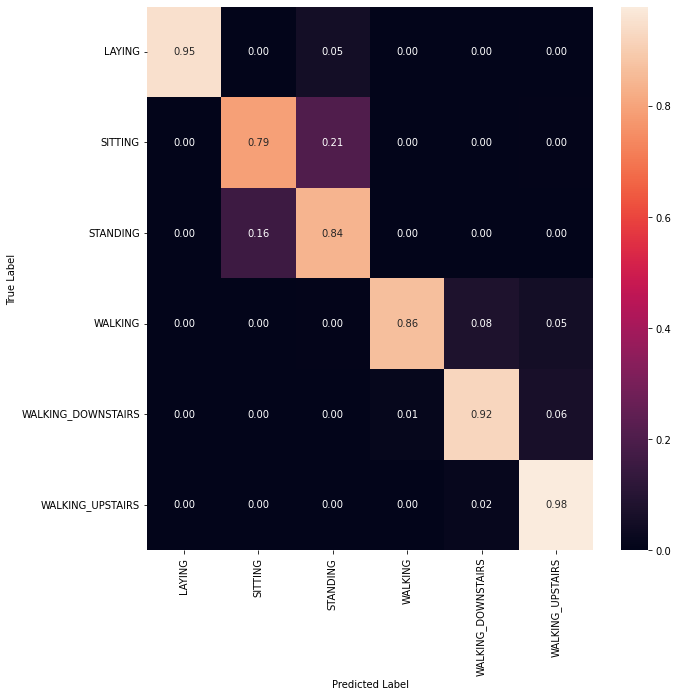

In [29]:
#Plot Normalized Confusion Matrix

# Calculate normalized confusion matrix
normalized_cm = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

#List out target names
target_names = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

#Use seaborn to plot heat map of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', xticklabels = target_names, yticklabels = target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show(block=False)

In [30]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 7ms/step - loss: 0.7389 - accuracy: 0.8897

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.7388768792152405, 0.8897183537483215]
